# Variational GP Implementation - fixing dimensions initialisation bug

* the current implementation of the VariationalGP in the Pyro library does not correctly implement `set_data(X, y)`
* this causes an issue if we want to add new datapoints to existing trained model and continue with training on the new dataset of the different size --> parameters within the implementation are not correctly braodcasted so the implementation break during matrix multiplication
* this makes the experiments with BO imposible for custom likelihoods

In [233]:
!pip install -q pyro-ppl

In [234]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

import tqdm

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

In [235]:
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

## 1. 1-D Test Functions

We generate the different 1-D data points from a various test functions.
The test function is specifed in the dictionary and the parameters to specify are:
 * `start`: the lower bound of the interval from which we sample the x-axis grid   
 * `end`: the upper bound of the interval from which we sample the x-axis grid
 * `num_of_points`: num of equidistant points to cover the x-axis grid
 * `num_of_points_tes`: num of equdistant points for the x-axis grid in which we evaluate the predicted function
 * `padding`: length of the intraval added to lower and upper bound to extend the train x-axis grid, its used for testing and measuring the ability of the model to extrapolate outside the training regions  

In [236]:
# define function in the torch specific way
fcn1 = lambda x: 0.5 * torch.sin(3 * x)
fcn2 = lambda x: torch.pow((6 * x - 2),2)* torch.sin(2 * (6 * x - 2))
fcn3 = lambda x: torch.Tensor(x) * torch.sin(x)
fcn4 = lambda x: 0.5 * torch.sin(x) - 0.02 * torch.pow((10 - x), 2) + 2

fcn_dict = {
    # label, [start, end, num_of_points, num_of_points_test, padding for test region ], fcn
    'fcn1': ["$f(x) = 0.5 \sin(3x)$", [0, 5, 20, 500, 0.5], fcn1],
    'fcn2': ["$f(x) = (6x - 2)^2 \sin[2(6x - 2)]$", [0, 1, 30, 500, 0.5], fcn2],
    'fcn3': ["$f(x) = x \sin(x)$", [0, 10, 1000, 500, 0.5], fcn3],
    'fcn4': ["$f(x) = 0.5 \sin(x) - 0.02(10 - x)^2 + 2$", [0, 20, 1000, 5000, 5], fcn4]
    }

In [237]:
# set hyperparameters for data generation

fcn_key_ = 'fcn4' # select function
N = 40 # number of training data points

__Generated variables__

*   variable X is x-axis grid over which the values of the function f(x) are being computed  
*   variable y correspond to f(x) values
* (X_train, y_train) is uniformly subsampled N points used for training
* (X_train, y_train_noise) is uniformly subsampled N points used for training with mixed in Gaussian noise with variance specified in variable noise_std
* X_test is x-grid which has extra padding on both side outside the train interval to test the ability of the model to extrapolate
* (X_test, y_test) fucntion f(x) computed on the testing interval X_test

In [238]:
# generate data
# get grid
X = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=fcn_dict[fcn_key_][1][2]).reshape(-1, 1)

# apply selected function
temp_y = fcn_dict[fcn_key_][2](torch.Tensor(X))
y = np.squeeze(temp_y.numpy())

# sample training set
X_train = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N,))
y_train = fcn_dict[fcn_key_][2](torch.Tensor(X_train))

X_test = np.squeeze(np.linspace(
    start=fcn_dict[fcn_key_][1][0] - fcn_dict[fcn_key_][1][4],
    stop=fcn_dict[fcn_key_][1][1] + fcn_dict[fcn_key_][1][4],
    num=fcn_dict[fcn_key_][1][3]))

temp_y_test = fcn_dict[fcn_key_][2](torch.Tensor(X_test))
y_test = np.squeeze(temp_y_test.numpy())

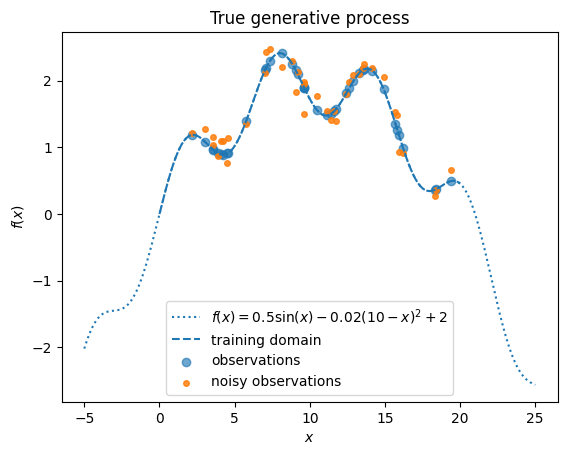

In [239]:
plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
plt.scatter(X_train, y_train, label="observations",  alpha=0.65, color=sns.color_palette()[0])
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

# Code

In [240]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.models import VariationalGP, VariationalSparseGP, SparseGPRegression
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like

In [241]:
def is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP or type(model) == VariationalGP_fixed:
    res = True
  else:
    res = False
  return res

def optimise(model, num_steps = 2000, lr_=0.005, MeanFieldElbo=False):
  pyro.clear_param_store()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
  if MeanFieldElbo==True:
      loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
  else:
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      variances.append(model.kernel.variance.item())
      lengthscales.append(model.kernel.lengthscale.item())
      if is_var(model)==True:
        noises.append(model.likelihood.variance.item())
      else:
        noises.append(model.noise.item())

      optimizer.zero_grad()
      loss = loss_fn(model.model, model.guide)
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

  model.set_mode("guide")
  print("\nvariance = {: .6f}".format(model.kernel.variance))
  print("lengthscale = {: .6f}".format(model.kernel.lengthscale))
  try:
    if is_var(model)==True:
      print("noise = {: .6f}".format(model.likelihood.variance))
    else:
      print("noise = {: .6f}".format(model.noise))
  except:
    pass
  res = {'model': model,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [242]:
def visualise_training(losses, variances, lengthscales, noises):
  fig, ax = plt.subplots(1, 4, figsize=(15, 3))
  ax[0].plot(losses)
  ax[0].set_title('loss')
  ax[1].plot(variances)
  ax[1].set_title('variance')
  ax[2].plot(lengthscales)
  ax[2].set_title('lengthscales')
  ax[3].plot(noises)
  ax[3].set_title('noise parameter')

def mse(predicted, labels):
    res = torch.mean((predicted - labels) ** 2)
    return res

def rmse(predicted, labels):
    res = torch.sqrt(mse(predicted, labels))
    return res

def visualise_results(model, grid=X_train, labels=y_train, title_=' '):
  with torch.no_grad():
    mean, cov = model.forward(torch.Tensor(X_test), full_cov=True)
    mean_train, cov_train = model.forward(torch.Tensor(np.squeeze(X)), full_cov=True)
  sd = cov.diag().sqrt().numpy()
  rmse_train = rmse(mean_train, torch.Tensor(y)).numpy()
  rmse_test = rmse(mean, torch.Tensor(y_test)).numpy()

  title_ = '{}\nrmse train: {: .4f}, rmse test: {: .4f}'.format(title_, rmse_train, rmse_test)
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
  plt.scatter(grid, labels, label="training observations")
  plt.plot(X_test, mean.numpy(), label="mean prediction")

  plt.fill_between(
      X_test.ravel(),
      mean.numpy() - 1.96 * sd,
      mean.numpy() + 1.96 * sd,
      alpha=0.3,
      label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title(title_)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

### Fixed VGP

In [243]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method


class VariationalGP_fixed(GPModel):
    r"""
    Variational Gaussian Process model.

    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form

    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),

    where :math:`p(y \mid f)` is the likelihood.

    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.

    .. note:: This model can be seen as a special version of
        :class:`.VariationalSparseGP` model with :math:`X_u = X`.

    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.

    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """

    def __init__(
        self,
        X,
        y,
        kernel,
        likelihood,
        mean_function=None,
        latent_shape=None,
        noise=None,
        whiten=False,
        jitter=1e-6,
    ):
        assert isinstance(
            X, torch.Tensor
        ), "X needs to be a torch Tensor instead of a {}".format(type(X))
        if y is not None:
            assert isinstance(
                y, torch.Tensor
            ), "y needs to be a torch Tensor instead of a {}".format(type(y))
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

        noise = self.X.new_tensor(1.0) if noise is None else noise
        self.noise = PyroParam(noise, constraints.positive)


    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[:: N + 1] += self.jitter + self.noise # add jitter to the diagonal
        Lff = torch.linalg.cholesky(Kff)

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(
                self._pyro_get_fullname("f"),
                dist.MultivariateNormal(zero_loc, scale_tril=identity).to_event(
                    zero_loc.dim() - 1
                ),
            )
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(
                self._pyro_get_fullname("f"),
                dist.MultivariateNormal(zero_loc, scale_tril=Lff).to_event(
                    zero_loc.dim() - 1
                ),
            )
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(
            self._pyro_get_fullname("f"),
            dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril).to_event(
                self.f_loc.dim() - 1
            ),
        )

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:

        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).

        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).

        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(
            Xnew,
            self.X,
            self.kernel,
            self.f_loc,
            self.f_scale_tril,
            full_cov=full_cov,
            whiten=self.whiten,
            jitter=self.jitter,
        )
        return loc + self.mean_function(Xnew), cov

    def update_data(self, X, y=None):
        """
        :param torch.Tensor X: A input data for training. Its first dimension is the
            number of data points.
        :param torch.Tensor y: An output data for training. Its last dimension is the
            number of data points.
        """
        if y is not None and X.size(0) != y.size(-1):
            raise ValueError(
                "Expected the number of input data points equal to the "
                "number of output data points, but got {} and {}.".format(
                    X.size(0), y.size(-1)
                )
            )

        y_batch_shape = y.shape[:-1] if y is not None else torch.Size([])
        self.latent_shape = self.latent_shape if self.latent_shape is not None else y_batch_shape

        N = X.size(0)
        f_loc = X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.X = X
        self.y = y


## Demostrating the bug

In [244]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

likelihood = gp.likelihoods.Gaussian()

In [245]:
kernel1 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp1 = VariationalGP(torch.Tensor(X_train[:-1]), torch.Tensor(y_train[:-1]),
                     kernel=kernel1,  likelihood=likelihood, whiten=True, jitter=1e-06)

In [246]:
vgp1_res = optimise(vgp1, 4000)

100%|██████████| 4000/4000 [00:32<00:00, 123.58it/s]


variance =  0.843601
lengthscale =  2.510898
noise =  0.000000


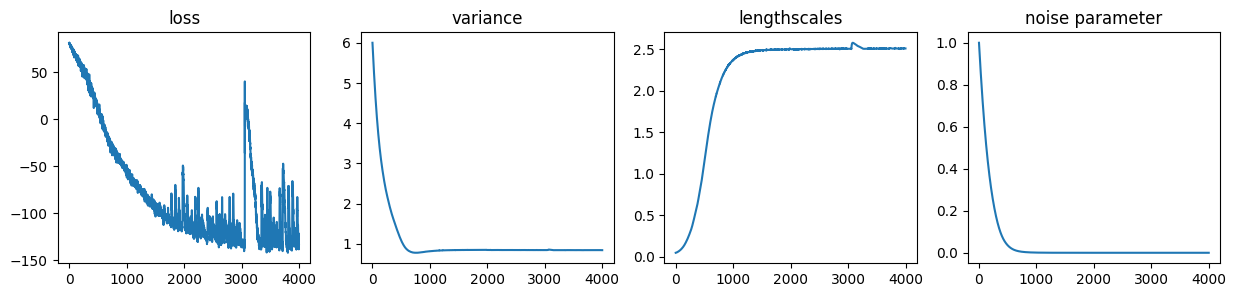

In [247]:
visualise_training(vgp1_res['losses'], vgp1_res['variances'], vgp1_res['lengthscales'], vgp1_res['noises'])

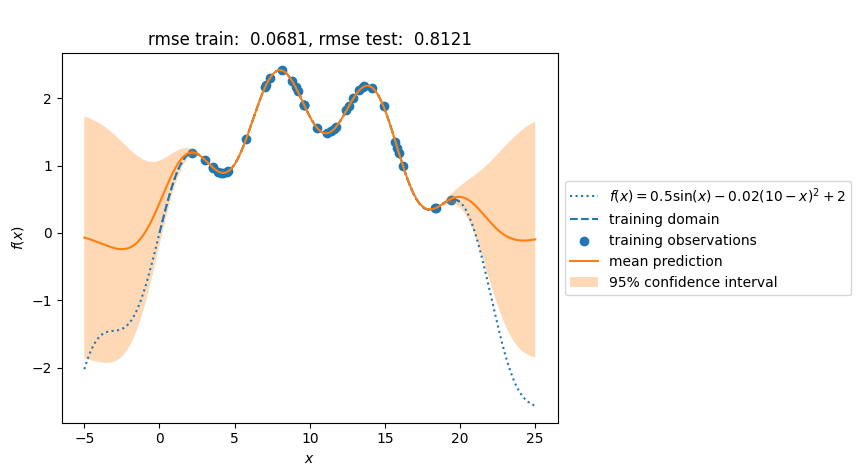

In [248]:
visualise_results(vgp1)

In [249]:
# iniate the VariationalGP object with the data
torch.Tensor(y_train[:-1]), torch.Tensor(y_train[-1]), torch.Tensor(y_train)

(tensor([0.4944, 2.1544, 2.1043, 0.3732, 1.9957, 1.2645, 0.9650, 2.1594, 1.5434,
         1.3935, 2.1618, 0.9722, 2.1987, 1.8172, 1.8921, 2.2579, 2.4101, 0.8942,
         2.1172, 1.3560, 0.8913, 2.1621, 1.1873, 1.5617, 0.9087, 1.4800, 1.5746,
         2.1744, 1.8772, 0.9130, 0.9965, 1.8863, 0.9099, 1.0787, 1.8953, 0.3660,
         1.5072, 1.9017, 1.1930]),
 tensor(2.3006),
 tensor([0.4944, 2.1544, 2.1043, 0.3732, 1.9957, 1.2645, 0.9650, 2.1594, 1.5434,
         1.3935, 2.1618, 0.9722, 2.1987, 1.8172, 1.8921, 2.2579, 2.4101, 0.8942,
         2.1172, 1.3560, 0.8913, 2.1621, 1.1873, 1.5617, 0.9087, 1.4800, 1.5746,
         2.1744, 1.8772, 0.9130, 0.9965, 1.8863, 0.9099, 1.0787, 1.8953, 0.3660,
         1.5072, 1.9017, 1.1930, 2.3006]))

In [250]:
vgp1.X, vgp1.X.shape, vgp1.y, vgp1.y.shape

(tensor([19.4011, 14.1564,  9.1877, 18.4150, 12.9005, 15.8230,  3.5721,  7.0222,
         11.6268,  5.7647,  9.0574,  3.5360,  7.1053, 12.4381,  9.6370,  8.8160,
          8.1456,  4.1088, 13.3008, 15.6975,  4.2073, 13.5348,  2.1947, 10.4750,
          4.5204, 11.1649, 11.7506, 13.6389, 14.9075,  4.5531, 16.1978, 12.6118,
          3.9178,  3.0545,  9.6301, 18.3501, 11.4408,  9.6166, 15.9212]),
 torch.Size([39]),
 tensor([0.4944, 2.1544, 2.1043, 0.3732, 1.9957, 1.2645, 0.9650, 2.1594, 1.5434,
         1.3935, 2.1618, 0.9722, 2.1987, 1.8172, 1.8921, 2.2579, 2.4101, 0.8942,
         2.1172, 1.3560, 0.8913, 2.1621, 1.1873, 1.5617, 0.9087, 1.4800, 1.5746,
         2.1744, 1.8772, 0.9130, 0.9965, 1.8863, 0.9099, 1.0787, 1.8953, 0.3660,
         1.5072, 1.9017, 1.1930]),
 torch.Size([39]))

In [251]:
vgp1.f_loc.shape, vgp1.f_scale_tril.shape
# vgp1.u_loc.shape, vgp1.u_scale_tril.shape

(torch.Size([39]), torch.Size([39, 39]))

In [252]:
vgp1.model()

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at likelihood.y
  warnings.warn(


tensor([0.4944, 2.1544, 2.1043, 0.3732, 1.9957, 1.2645, 0.9650, 2.1594, 1.5434,
        1.3935, 2.1618, 0.9722, 2.1987, 1.8172, 1.8921, 2.2579, 2.4101, 0.8942,
        2.1172, 1.3560, 0.8913, 2.1621, 1.1873, 1.5617, 0.9087, 1.4800, 1.5746,
        2.1744, 1.8772, 0.9130, 0.9965, 1.8863, 0.9099, 1.0787, 1.8953, 0.3660,
        1.5072, 1.9017, 1.1930])

In [253]:
vgp1.guide()

In [254]:
with torch.no_grad():
    print(vgp1.forward(torch.Tensor(X_test), full_cov=True))

(tensor([-0.0694, -0.0697, -0.0701,  ..., -0.0960, -0.0958, -0.0956]), tensor([[ 8.3883e-01,  8.3880e-01,  8.3876e-01,  ..., -6.1463e-04,
         -6.1281e-04, -6.1099e-04],
        [ 8.3880e-01,  8.3877e-01,  8.3874e-01,  ..., -6.1772e-04,
         -6.1589e-04, -6.1406e-04],
        [ 8.3876e-01,  8.3874e-01,  8.3872e-01,  ..., -6.2082e-04,
         -6.1898e-04, -6.1714e-04],
        ...,
        [-6.1463e-04, -6.1772e-04, -6.2082e-04,  ...,  7.9455e-01,
          7.9476e-01,  7.9496e-01],
        [-6.1281e-04, -6.1589e-04, -6.1898e-04,  ...,  7.9476e-01,
          7.9497e-01,  7.9517e-01],
        [-6.1099e-04, -6.1406e-04, -6.1714e-04,  ...,  7.9496e-01,
          7.9517e-01,  7.9538e-01]]))


In [255]:
# set new data
vgp1.set_data(torch.Tensor(X_train), torch.Tensor(y_train))

In [256]:
vgp1.X, vgp1.X.shape, vgp1.y, vgp1.y.shape

(tensor([19.4011, 14.1564,  9.1877, 18.4150, 12.9005, 15.8230,  3.5721,  7.0222,
         11.6268,  5.7647,  9.0574,  3.5360,  7.1053, 12.4381,  9.6370,  8.8160,
          8.1456,  4.1088, 13.3008, 15.6975,  4.2073, 13.5348,  2.1947, 10.4750,
          4.5204, 11.1649, 11.7506, 13.6389, 14.9075,  4.5531, 16.1978, 12.6118,
          3.9178,  3.0545,  9.6301, 18.3501, 11.4408,  9.6166, 15.9212,  7.3594]),
 torch.Size([40]),
 tensor([0.4944, 2.1544, 2.1043, 0.3732, 1.9957, 1.2645, 0.9650, 2.1594, 1.5434,
         1.3935, 2.1618, 0.9722, 2.1987, 1.8172, 1.8921, 2.2579, 2.4101, 0.8942,
         2.1172, 1.3560, 0.8913, 2.1621, 1.1873, 1.5617, 0.9087, 1.4800, 1.5746,
         2.1744, 1.8772, 0.9130, 0.9965, 1.8863, 0.9099, 1.0787, 1.8953, 0.3660,
         1.5072, 1.9017, 1.1930, 2.3006]),
 torch.Size([40]))

In [257]:
vgp1.f_loc.shape, vgp1.f_scale_tril.shape

(torch.Size([39]), torch.Size([39, 39]))

In [258]:
vgp1.model()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x40 and 39x1)

In [259]:
with torch.no_grad():
    print(vgp1.forward(torch.Tensor(X_test), full_cov=True))

RuntimeError: shape '[40, -1]' is invalid for input of size 39

In [260]:
vgp1.likelihood.variance

tensor(3.0483e-07, grad_fn=<AddBackward0>)

## Testing the fix

In [261]:
kernel2 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp1_fixed = VariationalGP_fixed(torch.Tensor(X_train[:-1]), torch.Tensor(y_train[:-1]),
                                 kernel=kernel2, likelihood=likelihood, noise=torch.tensor([0.]), whiten=True, jitter=1e-06)

In [262]:
vgp1_fixed.latent_shape

torch.Size([])

In [263]:
vgp1_fixed_res = optimise(vgp1_fixed, 4000)

100%|██████████| 4000/4000 [00:33<00:00, 117.95it/s]


variance =  0.769195
lengthscale =  1.401538
noise =  0.000000


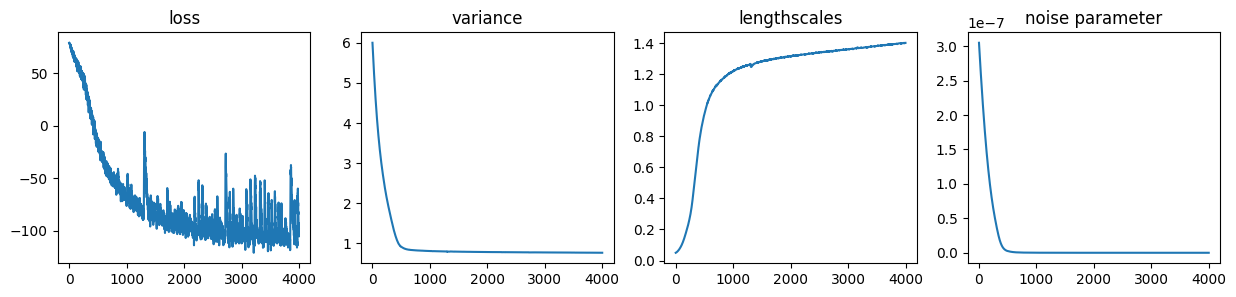

In [264]:
visualise_training(vgp1_fixed_res['losses'], vgp1_fixed_res['variances'], vgp1_fixed_res['lengthscales'], vgp1_fixed_res['noises'])

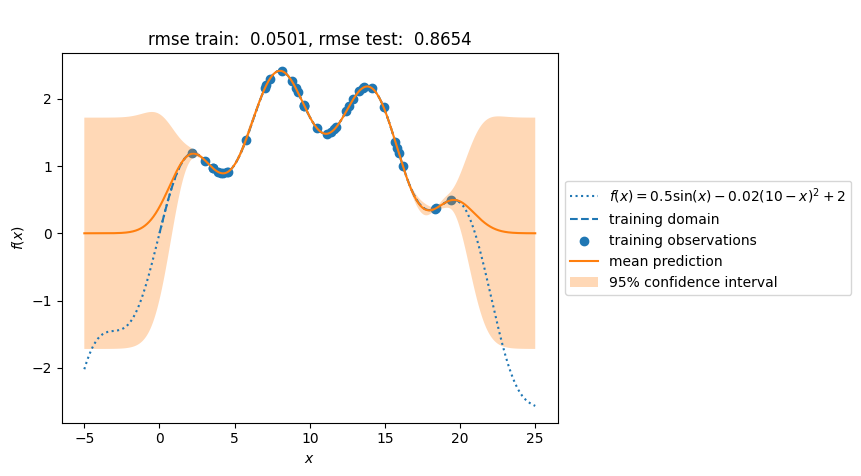

In [265]:
visualise_results(vgp1_fixed)

In [266]:
vgp1_fixed.f_loc.shape, vgp1_fixed.f_scale_tril.shape

(torch.Size([39]), torch.Size([39, 39]))

In [267]:
vgp1_fixed.update_data(torch.Tensor(X_train), torch.Tensor(y_train))

In [268]:
vgp1_fixed.f_loc.shape, vgp1_fixed.f_scale_tril.shape

(torch.Size([40]), torch.Size([40, 40]))

In [269]:
with torch.no_grad():
    print(vgp1_fixed.forward(torch.Tensor(X_test), full_cov=True))

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([[0.7692, 0.7692, 0.7692,  ..., 0.0000, 0.0000, 0.0000],
        [0.7692, 0.7692, 0.7692,  ..., 0.0000, 0.0000, 0.0000],
        [0.7692, 0.7692, 0.7692,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.7692, 0.7692, 0.7692],
        [0.0000, 0.0000, 0.0000,  ..., 0.7692, 0.7692, 0.7692],
        [0.0000, 0.0000, 0.0000,  ..., 0.7692, 0.7692, 0.7692]]))


In [270]:
vgp1_fixed.likelihood.variance

tensor(6.3275e-13, grad_fn=<AddBackward0>)

In [271]:
vgp1_fixed_res2 = optimise(vgp1_fixed, 4000)

100%|██████████| 4000/4000 [00:32<00:00, 122.21it/s]


variance =  0.710252
lengthscale =  2.416408
noise =  0.000000


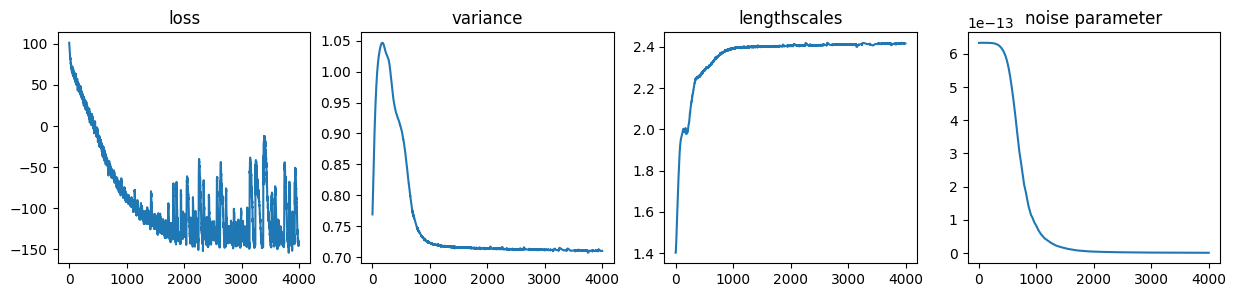

In [272]:
visualise_training(vgp1_fixed_res2['losses'], vgp1_fixed_res2['variances'], vgp1_fixed_res2['lengthscales'], vgp1_fixed_res2['noises'])

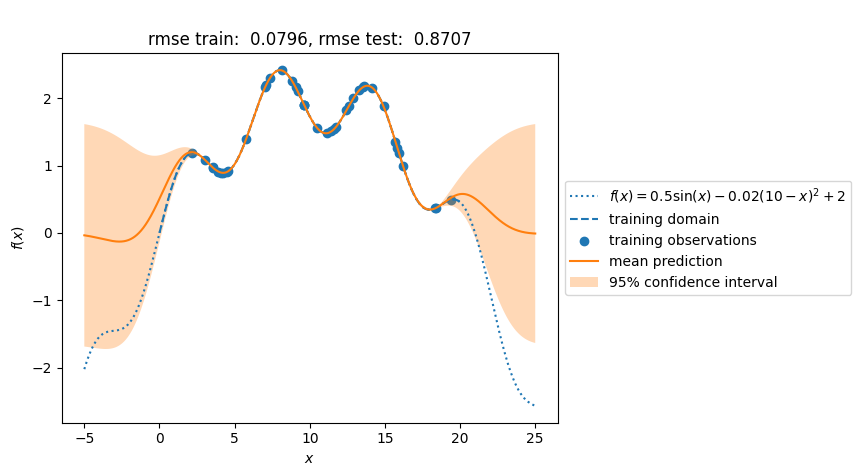

In [273]:
visualise_results(vgp1_fixed)